<a href="https://colab.research.google.com/github/DirectriX01/miidas/blob/master/Part2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task-2(Image Classification)
**Part 2** : Notebook1: Train on the given dataset(0..9) Labels using a CNN

**Note to the Examiner: I have the model-name legend in the end to avoid confusion over names*

The dataset has been uploaded on google drive on the path `/content/gdrive/MyDrive/train`. We use the `drive.mount()` method to load the dataset into our environment.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os 
from pprint import pprint
file_list = sorted(os.listdir('/content/gdrive/MyDrive/train2'))

###Installing GPU Enabled framework
The default tensorflow framework is uninstalled in favor of tensorflow-gpu which is compatible for training in Colab's GPU environment. The inbuilt !pip command is used for managing packages. The &> /dev/null option was used to ignore 'requirement satifisied' from being printed while installing tensorflow-gpu


In [ ]:
!pip uninstall tensorflow  -y 
!pip install tensorflow-gpu &> /dev/null # stable

import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.4.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5939962668637211689, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14646682624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5679109626440330320
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]


###1.2 Packages

* numpy is the main package for scientific computing with Python.

* matplotlib is a library to plot graphs in Python.

* Keras API will be used for training the model

* cv2 - OpenCv is an library built for various computer vision functions

In [ ]:
import numpy as np
import cv2
from tensorflow.keras import datasets, layers, models, losses
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

###Preprocessing: 

In [ ]:
path = '/content/gdrive/MyDrive/train2'
dirs = os.listdir(path)
# print(list(dirs))
path2 ='/content/gdrive/MyDrive/Train2_Crop'
if not(os.path.exists(path2)):
  os.mkdir(path2)
  for dir_name in dirs:
    img_list = os.listdir(os.path.join(path,dir_name))
    os.mkdir(os.path.join(path2,dir_name))
    # print(img_list)
    for img in img_list:
      # print(img)
      image = cv2.imread(os.path.join(path,dir_name,img))
      original = image.copy()
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

      cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = cnts[0] if len(cnts) == 2 else cnts[1]
      x,y,w,h = cv2.boundingRect(cnts[0])
      cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
      ROI = original[y:y+h, x:x+w]
      cv2.imwrite(os.path.join(path2,dir_name,img), ROI)
      # cv2_imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path2, target_size=(28,28), class_mode='categorical')

Found 400 images belonging to 10 classes.


In [ ]:
print("Batch Size for Input Image : ",train[0][0].shape)
print("Image Size of first image : ",train[0][0][0].shape)

Batch Size for Input Image :  (32, 28, 28, 3)
Image Size of first image :  (28, 28, 3)


Text(0.5, 1.0, '(array([5]),)')

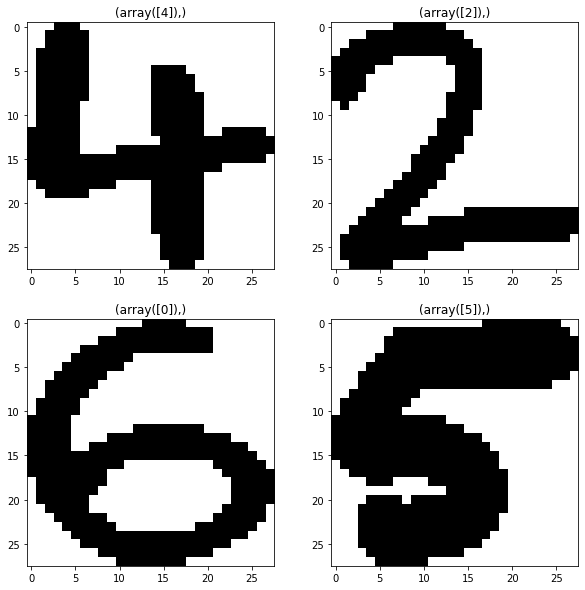

In [ ]:
fig , axs = plt.subplots(2,2 ,figsize = (10,10))

axs[0][0].imshow(train[0][0][12])
axs[0][0].set_title(np.where(train[0][1][12]==1))

axs[0][1].imshow(train[0][0][26])
axs[0][1].set_title(np.where(train[0][1][26]==1))


axs[1][0].imshow(train[0][0][10])
axs[1][0].set_title(np.where(train[0][1][18]==1))

axs[1][1].imshow(train[0][0][13])
axs[1][1].set_title(np.where(train[0][1][13]==1))



###**Architecture of the model:**

I have made significant changes to the architecture from what it was in part 1:

Few Changes in the architecture: 
  *   Halved the filters of Convolutions and Max-Pooling by 2, 4 in some cases
      *   Removed the stride from the first filter

  * Dense layers have 64 logits, contrary to 4096 in the original one.

  * Changed the output logits to 10

  * Removed one whole convolution block, as we do not have complex features thus we don't require complex learning functions 

  * The input size is changed to (28,28,3) according to the MNIST images to avoid resizing(to 227,227,3) and interpolation of images leading to overfitting. Thus the parameters have been reduced to 145k from 58 million. 

  * Added two dropout layers

In [ ]:
def ModifiedNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(48,(3,3),padding='valid',name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(64,(3,3),padding = 'valid' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(96, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(   name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(   name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(32, activation = 'relu', name = "fc0")(X)
    X = Dropout(0.4)(X)
    
    X = Dense(32, activation = 'relu', name = 'fc1')(X)
    X = Dropout(0.4)(X) 
    
    X = Dense(10,activation='softmax',name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ModifiedNet')

    return model

##**Training the model**

---

In [ ]:
modelA = ModifiedNet(train[0][0].shape[1:])

In [ ]:
modelA.summary()

Model: "ModifiedNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 26, 26, 48)        1344      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 26, 26, 48)        192       
_________________________________________________________________
activation_16 (Activation)   (None, 26, 26, 48)        0         
_________________________________________________________________
max0 (MaxPooling2D)          (None, 12, 12, 48)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 10, 64)        27712     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 10, 10, 64)        

###**Compiling the model**
  * Optimizer: Adam Optimizer
  * Loss: Categorical crossentropy

In [ ]:
modelA.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

###**Training the model**
  * Since less availiblity of data, and high number of parameters, the model is expected to overfit on the dataset. However adding dropout has helped us with the epoch number

In [ ]:
history_scratch = modelA.fit(train,epochs=50)

Epoch 1/50
13/13 [==============================] - 2s 82ms/step - loss: 2.6597 - accuracy: 0.1312
Epoch 2/50
13/13 [==============================] - 1s 85ms/step - loss: 2.0751 - accuracy: 0.2299
Epoch 3/50
13/13 [==============================] - 1s 84ms/step - loss: 1.8614 - accuracy: 0.3257
Epoch 4/50
13/13 [==============================] - 1s 83ms/step - loss: 1.7164 - accuracy: 0.4087
Epoch 5/50
13/13 [==============================] - 1s 83ms/step - loss: 1.5011 - accuracy: 0.4744
Epoch 6/50
13/13 [==============================] - 1s 84ms/step - loss: 1.4425 - accuracy: 0.4606
Epoch 7/50
13/13 [==============================] - 1s 83ms/step - loss: 1.3147 - accuracy: 0.5108
Epoch 8/50
13/13 [==============================] - 1s 85ms/step - loss: 1.2126 - accuracy: 0.5540
Epoch 9/50
13/13 [==============================] - 1s 86ms/step - loss: 1.0927 - accuracy: 0.5824
Epoch 10/50
13/13 [==============================] - 1s 85ms/step - loss: 1.0118 - accuracy: 0.6371
Epoch 11/

###**Saving the model and weights**
  * Optimizer: Adam Optimizer
  * Loss: Categorical crossentropy

In [ ]:
modelA.save('/content/gdrive/MyDrive/Checkpoints/train_model.h5')

In [ ]:
modelA.save_weights('/content/gdrive/MyDrive/Checkpoints/train_weights.h5')

##Training MNIST From Scratch


In [ ]:
#importing from keras API
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

#Since our input images have 3 channels(ImageDataGenerator is color=rgb by default) we add 3 dimensions
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(x_train.shape)

(60000, 28, 28, 3)


In [ ]:
modelB = ModifiedNet(x_train[0].shape)

###Compiling the model:
After observing 

In [ ]:
modelB.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history2_scratch = modelB.fit(x_train, y_train, batch_size=64, epochs=10)


Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.9814 - accuracy: 0.6660
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.2211 - accuracy: 0.9330
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1765 - accuracy: 0.9469
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1516 - accuracy: 0.9555
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1295 - accuracy: 0.9609
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1280 - accuracy: 0.9627
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1078 - accuracy: 0.9672
Epoch 8/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1103 - accuracy: 0.9686
Epoch 9/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0977 - accuracy: 0.9709
Epoch 10/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1011 - accuracy: 0.9716

###Loading the previously trained model

In [ ]:
from keras.models import load_model
modelC = load_model('/content/gdrive/MyDrive/Checkpoints/train_model.h5')

In [ ]:
modelC.summary()

Model: "ModifiedNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 26, 26, 48)        1344      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 26, 26, 48)        192       
_________________________________________________________________
activation_16 (Activation)   (None, 26, 26, 48)        0         
_________________________________________________________________
max0 (MaxPooling2D)          (None, 12, 12, 48)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 10, 64)        27712     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 10, 10, 64)        

###Training on the previously loaded model
  *We have not specified either losses or optimizer, they were already there from the loaded model.


In [ ]:
history2_pretrained = modelC.fit(x_train, y_train, batch_size=64, epochs=10)


Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3642 - accuracy: 0.8883
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2124 - accuracy: 0.9350
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1678 - accuracy: 0.9500
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1404 - accuracy: 0.9587
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1282 - accuracy: 0.9613
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1168 - accuracy: 0.9662
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1116 - accuracy: 0.9675
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1022 - accuracy: 0.9693
Epoch 9/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1061 - accuracy: 0.9686
Epoch 10/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0907 - accuracy: 0.9720

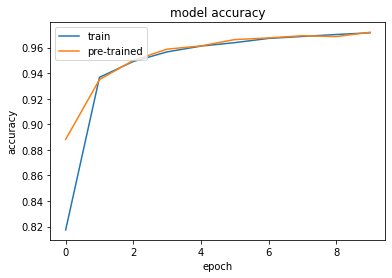

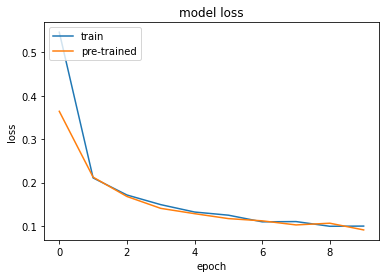

In [ ]:
plt.plot(history2_scratch.history['accuracy'])
plt.plot(history2_pretrained.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'pre-trained'], loc='upper left')
plt.show()
plt.plot(history2_scratch.history['loss'])
plt.plot(history2_pretrained.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'pre-trained'], loc='upper left')
plt.show()

###Analysis:

Pre_trained weights  | Scratch Initialized 
-------------------|------------------
97.2 Accuracy      | 97.16 Accuracy 
0.0907 Loss      | 0.101 Loss 

###Few Inferences we can make:

* The training data has an impact on our learning rate. Even though the final accuracy is near same for both models, owing to the fact that the network is extensive. We can observe from the graph that pretrained model accuracy is higher than the from one scratch initialized. This can be attirbuted to the fact that the features learned in the first part helped the model to learn features. 


* When loss of both models is compared it is observed that same trends can be found. Another observation can be made that initial loss for the model which was pretrained is very less compared to the scratch trained one. Therefore the model converges faster than scratch one.

If we equate with a real life example, Suppose a person learns to drive a bicycle and then attends learns to drive a scooty, they will learn faster than someone who is new to learning scooty without having experience in riding a bike. This is what is called Transfer learning


#Part 3
 
 ***

###Basic Preprocessing

In [ ]:
!unzip /content/gdrive/MyDrive/mnistTask3.zip > /dev/null

In [ ]:
path2 = '/content/mnistTask'
noise_datagen = ImageDataGenerator(rescale=1. / 255)
ntrain = train_datagen.flow_from_directory(path2, target_size=(28,28), class_mode='categorical')

Found 60000 images belonging to 10 classes.


In [ ]:
nModel_scratch = ModifiedNet(ntrain[0][0].shape[1:])

In [ ]:
nModel_scratch.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

###Model Training

Using more than 10 epochs won't yield results since we are training on noise and the computer will keep adding and removing losses ranndomly

In [ ]:
historyB_scratch = nModel_scratch.fit(ntrain,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 2.3026 - accuracy: 0.1025
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 2.3027 - accuracy: 0.1002
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 2.3027 - accuracy: 0.1019
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3027 - accuracy: 0.1010
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 2.3026 - accuracy: 0.1009
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3027 - accuracy: 0.1012
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3026 - accuracy: 0.1017
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3027 - accuracy: 0.1011
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3027 - accuracy: 0.0995
Epoch 10/10
1875/1875 [==============================] - 18s 10ms/st

In [ ]:
nModel_scratch.evaluate(x_test,y_test,batch_size=32)

313/313 [==============================] - 1s 3ms/step - loss: 11.0989 - accuracy: 0.0454


[11.098945617675781, 0.04540000110864639]

In [ ]:
nModel_pretrained = load_model('/content/gdrive/MyDrive/Checkpoints/train_model.h5')

In [ ]:
historyB_pretrained = modelC.fit(ntrain, batch_size=64, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3027 - accuracy: 0.0996
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3027 - accuracy: 0.1010
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3027 - accuracy: 0.1018
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3026 - accuracy: 0.1010
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3026 - accuracy: 0.1013
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3027 - accuracy: 0.1001
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.3027 - accuracy: 0.1018
Epoch 8/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3026 - accuracy: 0.0989
Epoch 9/10
1875/1875 [==============================] - 19s 10ms/step - loss: 2.3027 - accuracy: 0.1006
Epoch 10/10
1875/1875 [==============================] - 19s 10m

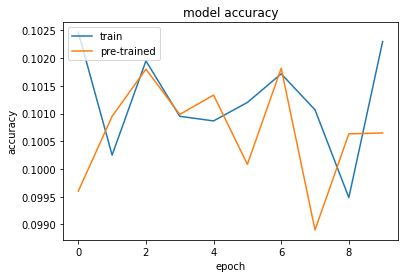

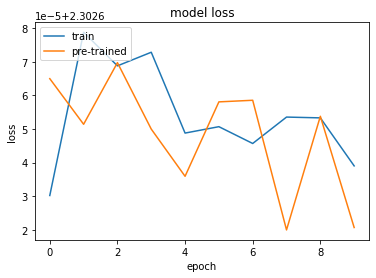

In [ ]:
plt.plot(historyB_scratch.history['accuracy'])
plt.plot(historyB_pretrained.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'pre-trained'], loc='upper left')
plt.show()
plt.plot(historyB_scratch.history['loss'])
plt.plot(historyB_pretrained.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'pre-trained'], loc='upper left')
plt.show()

In [ ]:
nModel_scratch.save('/content/gdrive/MyDrive/Checkpoints/ntrain_model.h5')
nModel_pretrained.save('/content/gdrive/MyDrive/Checkpoints/npretrained_model.h5')

Observations

* When loss of both models is compared. It seen that loss of pre_trained model is always less than that of scratch trained one. The reason we can say is that the pre_trained model had less training samples, and a model with a large number of parameters, therefore the model did overfit, that is learnt unncessary features such a noise in the images. 

Since the model here is about training noise, it came to our expectation, that the pretrained was better in predicting noise than the scratch trained one. Showing that transfer learning again indeed helped in learning features
